In [1]:
import sys
sys.path.append('../')
import numpy as np
from pygcn.pygcn.utils import load_data, encode_onehot, normalize
import scipy
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import networkx as nx
from scipy.sparse import coo_matrix
from tqdm import tqdm_notebook as tqdm
import scipy.sparse as sp
import torch
from lanczos import lanczos_algorithm

In [2]:
# n=20
# G = nx.fast_gnp_random_graph(n,0.8)
# A = nx.adjacency_matrix(G).todense()
# S = get_s(A)
# Q, T = lanczos_algorithm(S)
# plt.matshow(S);
# plt.colorbar()
# plt.show()

In [3]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(path = 'pygcn/data/cora/')

Loading cora dataset...


In [4]:
from scipy.sparse import csr_matrix

A = csr_matrix(adj.detach().to_dense().numpy())

In [5]:
def get_s(A):
    D = np.diag(np.array(A.sum(0))[0])
    D = sqrtm(np.linalg.inv(D))
    return np.array(D@A@D)

In [6]:
S = get_s(A)

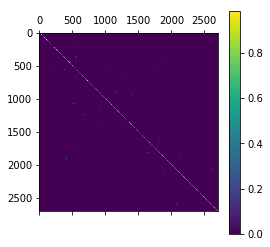

In [7]:
plt.matshow(S)
plt.colorbar()
plt.show()

In [8]:
k = 1000
Q, T = lanczos_algorithm(S, k)

 37%|███▋      | 367/1000 [00:10<00:17, 36.68it/s]/opt/anaconda/anaconda3/lib/python3.6/site-packages/tqdm/_monitor.py:89: TqdmSynchronisationWarning: Set changed size during iteration (see https://github.com/tqdm/tqdm/issues/481)
  TqdmSynchronisationWarning)
100%|██████████| 1000/1000 [00:27<00:00, 36.34it/s]


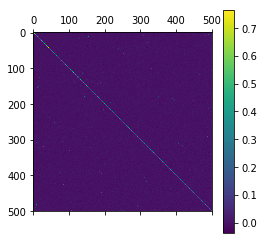

In [9]:
S_h=Q@T@Q.T
plt.matshow(S_h[:500,:500]);
plt.colorbar()
plt.show()

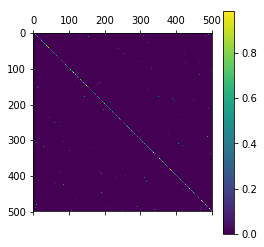

In [10]:
plt.matshow(S[:500,:500]);
plt.colorbar()
plt.show()

In [11]:
from torch import nn

class LanczosNet(nn.Module):
    def __init__(self, k, feat_dim, num_classes, short_scales, long_scales):
        super(LanczosNet, self).__init__()
        '''
        k - size of R, k<=n
        feat_dim - embeddings dimentionality
        short_scales - scales for direct filters S^qX
        long_scales - scales of spectral filters VRV^T
        '''
        self.short_scales = short_scales
        self.long_scales = long_scales
        self.mlp = nn.Linear(k, k)
        
        inner_dim = (len(short_scales)+len(long_scales))*feat_dim
        
        self.conv1 = GraphConvolution(inner_dim, 512)
        self.conv2 = GraphConvolution(512, num_classes)
        
#         self.W = nn.Parameter(torch.ones(n), requires_grad=True)
        
    def forward(self, adj, X, S, V, R):
        Y = X
        Z = Y
        features = []
        for l in range(1, self.short_scales[-1] + 1):
            Z = torch.mm(S,Z)
            if l in self.short_scales:
                features.append(Z)
#         print(Z.shape)


        for i in self.long_scales:
            R_h = self.mlp(R**i)
            Z = torch.mm(V, torch.diag(R_h))
            Z = torch.mm(Z, V.t())
            Z = torch.mm(Z, Y)
#             print(Z.shape)
            features.append(Z)
        Z = torch.cat(features, 1)
        Z = self.conv1(Z, adj)
        Z = self.conv2(Z, adj)        
            
        return F.log_softmax(Z)

class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / np.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)
        if self.bias is not None:
            self.bias.data.uniform_(-stdv, stdv)

    def forward(self, input, adj):
        support = torch.mm(input, self.weight)
        output = torch.spmm(adj, support)
        if self.bias is not None:
            return output + self.bias
        else:
            return output
        

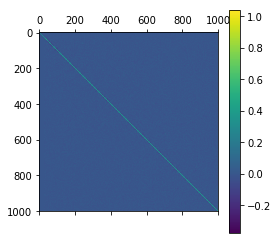

In [12]:
plt.matshow(T);
plt.colorbar()
plt.show()

In [13]:
from scipy.linalg import eigh_tridiagonal

d = np.diagonal(T, 0)
e = np.diagonal(T, -1)
w, B = eigh_tridiagonal(d,e)

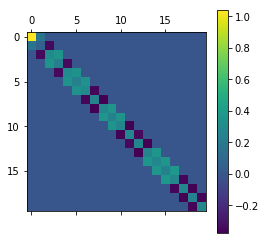

In [14]:
R = np.diag(w)
plt.matshow((B@R@B.T)[:20,:20]);
plt.colorbar()
plt.show()

In [15]:
n = adj.shape[0]
feat_dim = 1433
short_scales = [1,3,5]
long_scales = [10,20,30]
num_classes = 7
model = LanczosNet(k, feat_dim,  num_classes, short_scales, long_scales)

In [17]:
import torch.nn.functional as F
import torch.optim as optim

from pygcn.pygcn.utils import accuracy

In [18]:
# from pygcn.models import GCN
# lr = 1e-2
# model = GCN(nfeat=features.shape[1],
#             nhid=16,
#             nclass=labels.max().item() + 1,
#             dropout=False)

# model = model.cuda()
# optimizer = optim.Adam(model.parameters(), lr=lr)

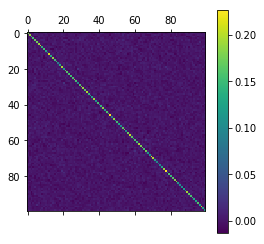

In [19]:
V = Q@B
plt.matshow((V@R@V.T)[600:700,600:700])
plt.colorbar()
plt.show()

In [20]:
# lanczos_net(torch.Tensor(adj.todense()), features, torch.Tensor(S), torch.Tensor(V), torch.Tensor(w))

In [22]:
lr = 1e-2
model = model.cuda()
optimizer = optim.Adam(model.parameters(), lr=lr)

A = torch.Tensor(A.todense()).cuda()
X = features.cuda()
S = torch.Tensor(S).cuda()
V = torch.Tensor(V).cuda()
w = torch.Tensor(w).cuda()
labels = labels.cuda()

In [23]:
def train(epoch):
    model.train()
    optimizer.zero_grad()
    output = model(A, X, S, V, w)
    loss_train = F.nll_loss(output[idx_train], labels[idx_train])
    acc_train = accuracy(output[idx_train], labels[idx_train])
    loss_train.backward()
    optimizer.step()

#     if not args.fastmode:
        # Evaluate validation set performance separately,
        # deactivates dropout during validation run.
    model.eval()
    output = model(A, X, S, V, w)

    loss_val = F.nll_loss(output[idx_val], labels[idx_val])
    acc_val = accuracy(output[idx_val], labels[idx_val])
    print('Epoch: {:04d}'.format(epoch+1),
          'loss_train: {:.4f}'.format(loss_train.item()),
          'acc_train: {:.4f}'.format(acc_train.item()),
          'loss_val: {:.4f}'.format(loss_val.item()),
          'acc_val: {:.4f}'.format(acc_val.item()))


def test():
    model.eval()
    output = model(A, X, S, V, w)
    loss_test = F.nll_loss(output[idx_test], labels[idx_test])
    acc_test = accuracy(output[idx_test], labels[idx_test])
    print("Test set results:",
          "loss= {:.4f}".format(loss_test.item()),
          "accuracy= {:.4f}".format(acc_test.item()))

In [24]:
epochs=80
for epoch in tqdm(range(epochs)):
    train(epoch)

A Jupyter Widget

/opt/anaconda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0001 loss_train: 1.9451 acc_train: 0.1000 loss_val: 1.4992 acc_val: 0.3933
Epoch: 0002 loss_train: 1.3513 acc_train: 0.4571 loss_val: 1.2000 acc_val: 0.6133
Epoch: 0003 loss_train: 0.8749 acc_train: 0.7786 loss_val: 0.9202 acc_val: 0.7767
Epoch: 0004 loss_train: 0.5243 acc_train: 0.9000 loss_val: 0.7611 acc_val: 0.8133
Epoch: 0005 loss_train: 0.3353 acc_train: 0.9500 loss_val: 0.6794 acc_val: 0.8200
Epoch: 0006 loss_train: 0.2282 acc_train: 0.9714 loss_val: 0.6455 acc_val: 0.8367
Epoch: 0007 loss_train: 0.1559 acc_train: 0.9643 loss_val: 0.6430 acc_val: 0.8300
Epoch: 0008 loss_train: 0.1020 acc_train: 0.9643 loss_val: 0.6634 acc_val: 0.8300
Epoch: 0009 loss_train: 0.0645 acc_train: 0.9857 loss_val: 0.6991 acc_val: 0.8200
Epoch: 0010 loss_train: 0.0396 acc_train: 0.9929 loss_val: 0.7452 acc_val: 0.8067
Epoch: 0011 loss_train: 0.0238 acc_train: 1.0000 loss_val: 0.7996 acc_val: 0.8033
Epoch: 0012 loss_train: 0.0165 acc_train: 1.0000 loss_val: 0.8598 acc_val: 0.8000
Epoch: 0013 loss